
# Data Visualization & Customer Segmentation using K-Means


# 본문

우리는 고객 세그먼트를 확인하고, 이 구분과 데이터에서 얻은 insight를 볼 것이다. 

이것은 어떻게 기업이 고객들에 행동을 하는 방식에 영향을 행사할 수 있는 실무 테크닉이다. 


# 참고할 점

본인은 시각화하는 요소를 customize하는데 시간을 많이 보낸다.

1) 왜냐하면 즐겁기 때문이다.

2) 또, 모든 시각화는 눈에 어필해야한다. 데이터 사이언티스트들과 분석가들이 간과하는 점이다. 모든 아이디어와 모델들은 팔려야한다. 그리고 미적 시각화는 그 목적에 중요하다.

이 notebook의 큰 부분은 결과를 시각화 하는것이다. 자세히 봐라.

In [1]:
import matplotlib as mpl
import matplotlib.font_manager as fm

mpl.rcParams['axes.unicode_minus']=False
path='/kaggle/input/malgun/malgun.ttf'
fontprop=fm.FontProperties(fname=path)

In [2]:
# Importing libs
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import plotly as py
import plotly.graph_objs as go
import os
py.offline.init_notebook_mode(connected = True)

In [3]:
# Quick overview of the data

df = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')
print(df.head(3))
print('----------')
print('Shape: ',df.shape)
print('----------')
print(df.dtypes)
print('----------')
print(df.describe())
print('---------- ')
print(df.isnull().sum())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
----------
Shape:  (200, 5)
----------
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object
----------
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.

In [4]:
# 시각화를 위한 feature 조작.

# Age bin / range
bins = [18, 22, 50, 70]
labels = ['Young', 'Adult', 'Senior']
df['Age Range'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)


# Age banding
def age_band(num):
    for i in range(1, 100):
        if num < 10*i :  return f'{(i-1) * 10} ~ {i*10}'

df['age_band'] = df['Age'].apply(age_band)


# 시각화를 해보자.

고객들의 일반적인 구성이 어떻게 되나?

In [5]:
# For viz: Ratio of Males & Females
# 팁 : value_counts로 쉽게 구할 수 있다. 단, index가 제대로 안갖춰진다.

x=df.groupby(['Gender'])['Gender'].count()
y=len(df)
r=((x/y)).round(2)

mf_ratio = pd.DataFrame(r).T

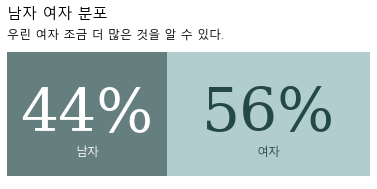

In [6]:
# 팁 : 무조건 숫자 등 바로 써야하면 ax.annotate 글자는 fig.text

fig, ax = plt.subplots(1,1,figsize=(6.5, 2.5))

ax.barh(mf_ratio.index, mf_ratio['Male'], 
        color='#244747', alpha=0.7, label='남자')
ax.barh(mf_ratio.index, mf_ratio['Female'], left=mf_ratio['Male'], 
        color='#91b8bd', alpha=0.7, label='여자')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])

# male percentage
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['Male'][i]*100)}%", 
                   xy=(mf_ratio['Male'][i]/2, i),
                   va = 'center', ha='center',fontsize=60, fontweight='light', fontfamily='serif',
                   color='white')

    ax.annotate("남자", 
                   xy=(mf_ratio['Male'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontproperties=fontprop,
                   color='white')
    
    
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['Female'][i]*100)}%", 
                   xy=(mf_ratio['Male'][i]+mf_ratio['Female'][i]/2, i),
                   va = 'center', ha='center',fontsize=60, fontweight='light', fontfamily='serif',
                   color='#244747')
    ax.annotate("여자", 
                   xy=(mf_ratio['Male'][i]+mf_ratio['Female'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontproperties=fontprop,
                   color='#244747')


# Title & Subtitle
fig.text(0.125,1.03,'남자 여자 분포',fontproperties=fontprop,fontsize=15, fontweight='bold')
fig.text(0.125,0.92,'우린 여자 조금 더 많은 것을 알 수 있다.',fontproperties=fontprop,fontsize=12)  

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    


#ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))

# Removing legend due to labelled plot
ax.legend().set_visible(False)
plt.show()

나이에 대해서는 어떻게 되나?

나중에 이런 모든 정보들이 clusters를 해석하는데 중요하다. 

그래서 뭐? 라고 묻는게 중요하다. 여자가 많다면 우리는 광고를 어떻게 다르게 해야하는지 같은 문제로 볼 수 있다.

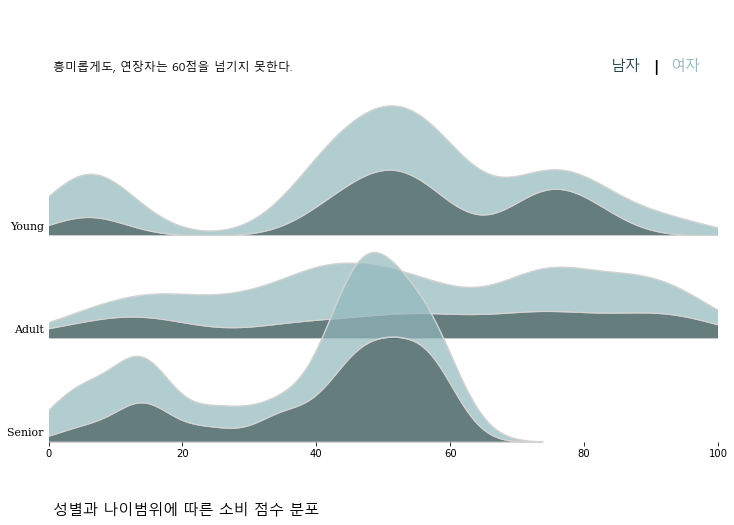

In [7]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(3,1)
gs.update(hspace= -0.55)

axes = list()
colors = ["#004c70", "#990000",'#990000']

for idx, cls, c in zip(range(4), df['Age Range'].unique(), colors):
    axes.append(fig.add_subplot(gs[idx, 0]))
    
    # you can also draw density plot with matplotlib + scipy.
    sns.kdeplot(x='Spending Score (1-100)', data=df[df['Age Range']==cls], 
                fill=True, ax=axes[idx], cut=3, bw_method=0.25, 
                lw=1.4, edgecolor='lightgray',multiple="stack", palette=['#91b8bd','#244747'], alpha=0.7,hue='Gender') 
    
    
    
               
    axes[idx].set_ylim(0, 0.04)
    axes[idx].set_xlim(0, 100)
    
    axes[idx].set_yticks([])
    if idx != 2 : axes[idx].set_xticks([])
    axes[idx].set_ylabel('')
    axes[idx].set_xlabel('')
    
    spines = ["top","right","left","bottom"]
    for s in spines:
        axes[idx].spines[s].set_visible(False)
        
    axes[idx].patch.set_alpha(0)
    axes[idx].text(-0.2,0.001,f'{cls} ',fontweight="light", fontfamily='serif', fontsize=11,ha="right")
    if idx != 4 : axes[idx].get_legend().remove() # changed to 4 to remove legend. This says, if it is not the 4th plot remove the legend
    

fig.text(0.13,0,'성별과 나이범위에 따른 소비 점수 분포',fontweight="bold", fontproperties=fontprop, fontsize=15)
fig.text(0.13,0.77,'흥미롭게도, 연장자는 60점을 넘기지 못한다.',fontproperties=fontprop,fontsize=12)

fig.text(0.776,0.77,"남자", fontweight="bold", fontproperties=fontprop, fontsize=15, color='#244247')
fig.text(0.825,0.77,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.845,0.77,"여자", fontweight="bold", fontproperties=fontprop, fontsize=15, color='#91b8bd')

plt.show()   

여기서 눈에 띄는 몇가지를 발견했다. 나이에 대해서 조금 더 본다.

In [8]:
# Some quick feature engineering, just in case

df['Gender 1/0'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)


In [9]:
def age_band(num):
    for i in range(1, 100):
        if num < 10*i :  return f'{(i-1) * 10} ~ {i*10}'

df['age_band'] = df['Age'].apply(age_band)



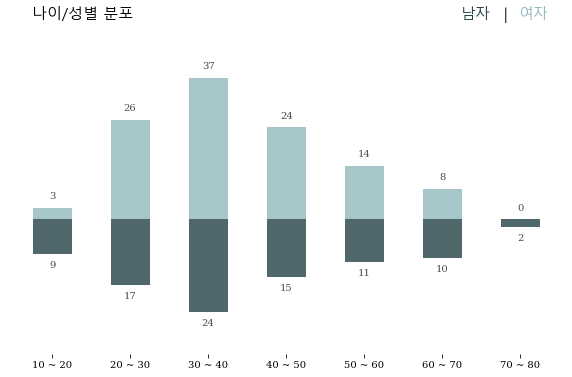

In [10]:
# 팁 : value_counts().reset_index(name='count')와 비슷할 것이다.

mf = df.groupby('Gender')['age_band'].value_counts().unstack().sort_index().fillna(0).astype(int)

female = mf.loc['Female']
male = -mf.loc['Male']

fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.bar(male.index, male, width=0.5, color='#244247', alpha=0.8, label='남자')
ax.bar(female.index, female, width=0.5, color='#91b8bd', alpha=0.8, label='여자')
ax.set_ylim(-35, 50)

# Annotations
for i in female.index:
    ax.annotate(f"{female[i]}", 
                   xy=(i, female[i] + 3),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='#4a4a4a')   

for i in male.index:
    ax.annotate(f"{-male[i]}", 
                   xy=(i, male[i] - 3),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='#4a4a4a')
    
 

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

ax.set_xticklabels(mf.columns, fontfamily='serif')
ax.set_yticks([])    

ax.legend().set_visible(False)
fig.text(0.16, 0.9, '나이/성별 분포', fontsize=15, fontweight='bold', fontproperties=fontprop)

fig.text(0.755,0.9,"남자", fontweight="bold", fontproperties=fontprop, fontsize=15, color='#244247')
fig.text(0.815,0.9,"|", fontweight="bold", fontproperties=fontprop, fontsize=15, color='black')
fig.text(0.835,0.9,"여자", fontweight="bold",fontproperties=fontprop, fontsize=15, color='#91b8bd')

plt.show()

눈에 띄는 나이 범위는 남녀 30~40대의 고객이 많다.

20~50대까지 중요한것 같다.

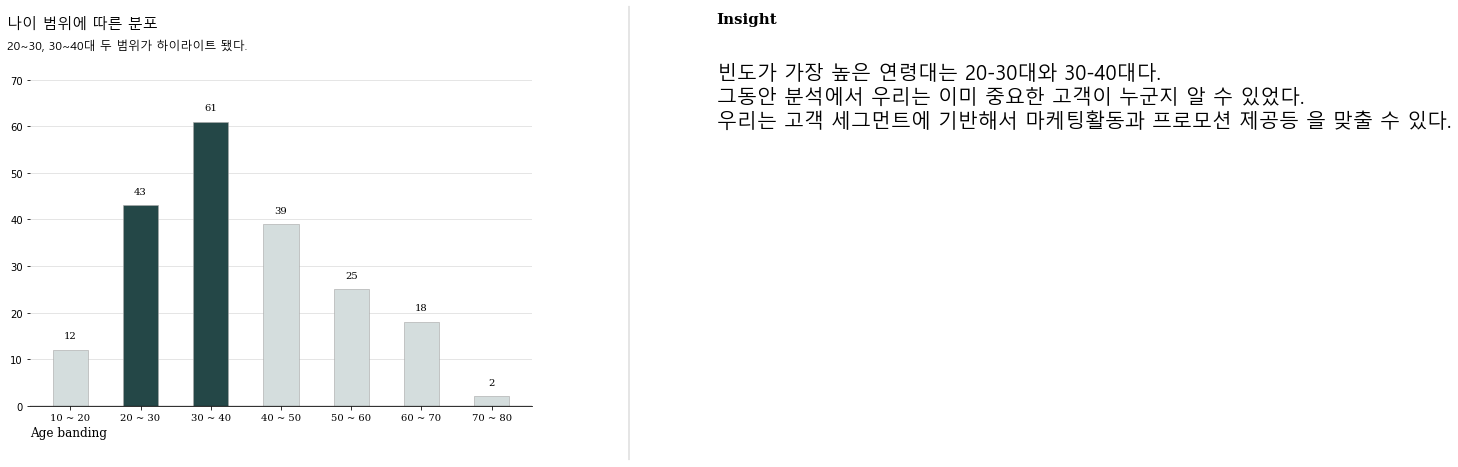

In [11]:
# Order for plotting categorical vars

ab_order = ['10 ~ 20', '20 ~ 30', '30 ~ 40','40 ~ 50','50 ~ 60' ,'60 ~ 70', '70 ~ 80']

data = df['age_band'].value_counts()[ab_order]

# Plot
# 팁 : 색상 하이라이트를 줄 때 

color_map = ['#d4dddd' for _ in range(9)]
color_map[2] = color_map[1] = '#244747' # color highlight

fig, ax = plt.subplots(1,1, figsize=(9, 6))
ax.bar(data.index, data, width=0.5, 
       edgecolor='darkgray',
       linewidth=0.6,color=color_map)


#annotations
for i in data.index:
    ax.annotate(f"{data[i]}", 
                   xy=(i, data[i] + 3), #i like to change this to roughly 5% of the highest cat
                   va = 'center', ha='center',fontweight='light', fontfamily='serif')



# Remove border from plot

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
# Tick labels

ax.set_xticklabels(data.index, fontfamily='serif', rotation=0)

# Title and sub-title

fig.text(0.09, 1, '나이 범위에 따른 분포', fontsize=15, fontweight='bold', fontproperties=fontprop)
fig.text(0.09, 0.95, '20~30, 30~40대 두 범위가 하이라이트 됐다.', fontsize=12, fontweight='light', fontproperties=fontprop)

fig.text(1.185, 1.01, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(1.185, 0.715, '''
빈도가 가장 높은 연령대는 20-30대와 30-40대다. 
그동안 분석에서 우리는 이미 중요한 고객이 누군지 알 수 있었다.
우리는 고객 세그먼트에 기반해서 마케팅활동과 프로모션 제공등 을 맞출 수 있다.
''', fontsize=20, fontweight='light', fontproperties=fontprop)

ax.grid(axis='y', linestyle='-', alpha=0.4)   

grid_y_ticks = np.arange(0, 75, 10) # y ticks, min, max, then step
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)

#Axis labels

plt.xlabel("Age banding", fontsize=12, fontweight='light', fontfamily='serif',loc='left',y=-1.5)
#plt.ylabel("Count", fontsize=12, fontweight='light', fontfamily='serif')
 #plt.legend(loc='upper right')
    
# thicken the bottom line if you want to
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

import matplotlib.lines as lines
l1 = lines.Line2D([1.05, 1.05], [0, 1.05], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])



plt.show()

# cluster를 위한 준비 : 데이터 분포가 어떻게 되는지?

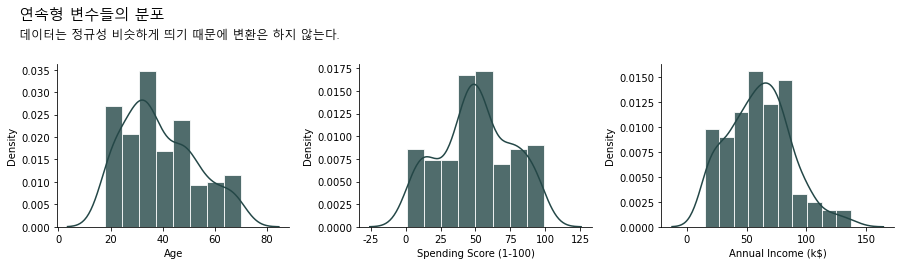

In [12]:
import matplotlib.gridspec as gridspec

# Create 2x2 sub plots
gs = gridspec.GridSpec(1, 3)

fig = plt.figure(figsize=(15, 3))

# Title and sub-title

fig.text(0.09, 1.09, '연속형 변수들의 분포', fontsize=15, fontweight='bold', fontproperties=fontprop)
fig.text(0.09, 1, '데이터는 정규성 비슷하게 띄기 때문에 변환은 하지 않는다.', fontsize=12, fontweight='light', fontproperties=fontprop)

# Grid spec layout

ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
ax1 = sns.distplot(df["Age"],color='#244747',hist_kws=dict(edgecolor="white", linewidth=1,alpha=0.8))

ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 1
ax2 = sns.distplot(df["Spending Score (1-100)"],color='#244747',hist_kws=dict(edgecolor="white", linewidth=1,alpha=0.8))

ax3 = fig.add_subplot(gs[0, 2]) # row 1, span all columns
ax3 = sns.distplot(df["Annual Income (k$)"],color='#244747',hist_kws=dict(edgecolor="white", linewidth=1,alpha=0.8))

sns.despine()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None) # useful for adjusting space between subplots


데이터가 극단적이지 않기때문에 변환은 하지 않는다.

# 연속형 변수들이 서로 관련이 있는지 본다.

통계적 plots은 변수들끼리 서로 관계가 있는지 확인할 수 있게 해준다. 

여기서 잠재적인 clusters를 볼 수 있다. 

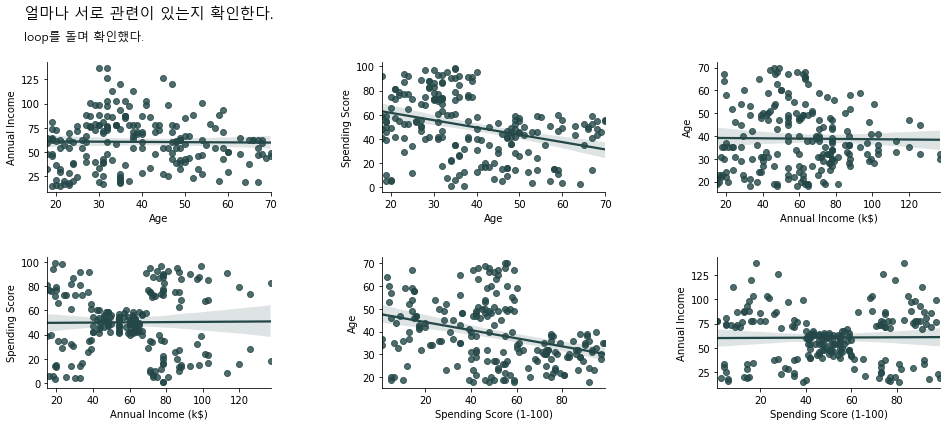

In [13]:
fig = plt.figure(figsize=(16, 6))

# Title and sub-title

fig.text(0.105, .98, '얼마나 서로 관련이 있는지 확인한다.', fontsize=15, fontweight='bold', fontproperties=fontprop)
fig.text(0.105, .93, 'loop를 돌며 확인했다.', fontsize=12, fontweight='light', fontproperties=fontprop)


n = 0 


for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    for y in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
        if x==y: continue

        n += 1
        plt.subplot(2 , 3 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df,color='#244747')
        sns.despine()
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None) # useful for adjusting space between subplot

plt.show()


# 흥미로운 plot을 확대해 보겠다. 

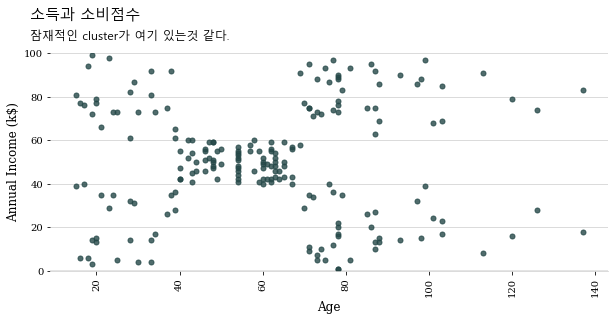

In [14]:

fig, ax = plt.subplots(figsize=(10,4))

# Title & Subtitle
fig.text(0.097,1,'소득과 소비점수', fontproperties=fontprop,fontsize=15, fontweight='bold')
fig.text(0.097,0.93,'잠재적인 cluster가 여기 있는것 같다. ', fontproperties=fontprop,fontsize=12)

# Ax spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.spines['bottom'].set_color('lightgray')

# Grid
ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgray', linestyle='-')

# Plot

plt.scatter(x = 'Annual Income (k$)' , y = 'Spending Score (1-100)' , data = df ,color='#244747',s = 25 , alpha = 0.8 )


# Tick control
plt.yticks(fontsize=10, fontfamily='serif',fontweight='light')
#ax.yaxis.set_ticks(np.arange(0,140,10))

plt.xticks(fontsize=10, fontfamily='serif',fontweight='light',rotation=90)


# Label control
ax.set_ylabel('Annual Income (k$)',fontfamily='serif',fontsize=12)
ax.set_xlabel('Age',fontfamily='serif',fontsize=12)

ax.set_ylim(0, 100)
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

plt.show()

# cluster 할 준비가 됐다.

In [15]:
# 방법은 k-means clustering을 한다. 
selected_cols = ["Spending Score (1-100)", "Annual Income (k$)", "Age"]
cluster_data = df.loc[:,selected_cols]

In [16]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

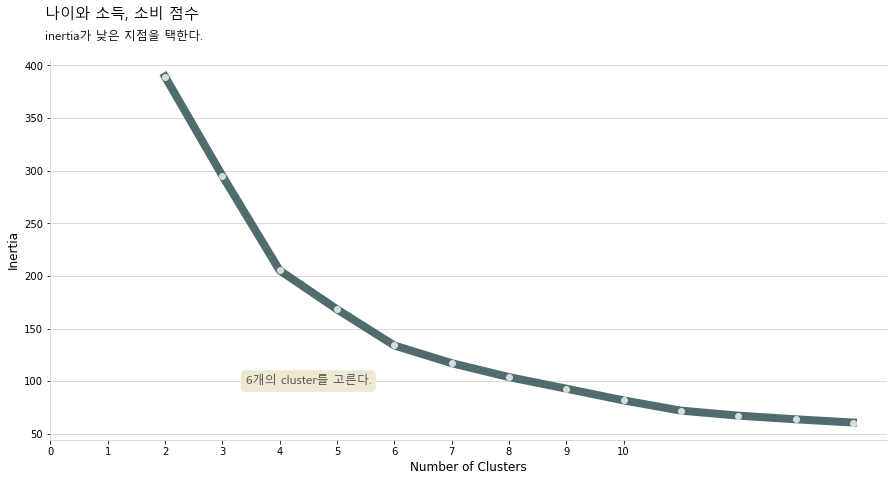

In [17]:
fig, ax = plt.subplots(figsize=(15,7))

clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(clusters_range,inertias, '-' , color='#244747',alpha = 0.8,linewidth=8)
plt.plot(clusters_range,inertias, 'o',linewidth=20,color='#d4dddd')    



##
plt.xlabel('Number of Clusters',fontsize=12) , plt.ylabel('Inertia',fontsize=12)
ax.xaxis.set_ticks(np.arange(0,11,1))

# Title & Subtitle
fig.text(0.12,0.96,'나이와 소득, 소비 점수',fontproperties=fontprop,fontsize=15, fontweight='bold')
fig.text(0.12,0.92,'inertia가 낮은 지점을 택한다.',fontproperties=fontprop,fontsize=12)


ax.annotate("6개의 cluster를 고른다.", 
            xy=(4.5, 100), fontsize=12,
            va = 'center', ha='center',
            color='#4a4a4a',fontproperties=fontprop,
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))



# Ax spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')

# Grid
ax.set_axisbelow(True)# Ax spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')
ax.yaxis.grid(color='lightgray', linestyle='-')
plt.show()

In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [19]:
# Running various cluster numbers with various random seeds

clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        results.append([c,r,silhouette_avg])

In [20]:
# Turn results in to a pivot table

result = pd.DataFrame(results, columns=["Number of clusters","Random seed","Silhouette_score"])
pivot_km = pd.pivot_table(result, index="Number of clusters", columns="Random seed",values="Silhouette_score")


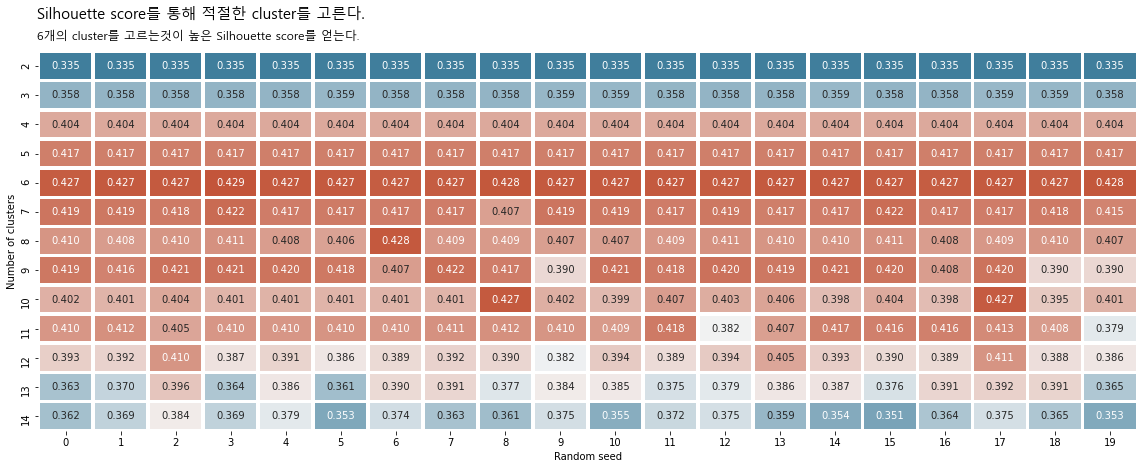

In [21]:
# Turn that pivot in to a nice visual

fig = plt.figure(figsize=(16, 6))

# Title and sub-title

fig.text(0.035, 1.05, 'Silhouette score를 통해 적절한 cluster를 고른다.', fontsize=15, fontweight='bold', fontproperties=fontprop)
fig.text(0.035, 1.001, '6개의 cluster를 고르는것이 높은 Silhouette score를 얻는다.', fontsize=12, fontweight='light', fontproperties=fontprop)

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(pivot_km, annot=True, linewidths=2.5, fmt='.3f', cmap=cmap,cbar=False)

plt.tight_layout()

In [22]:
# Six looks to be a good number of clusters. We will also assign these clusters to a df
kmeans_sel = KMeans(n_clusters=6, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

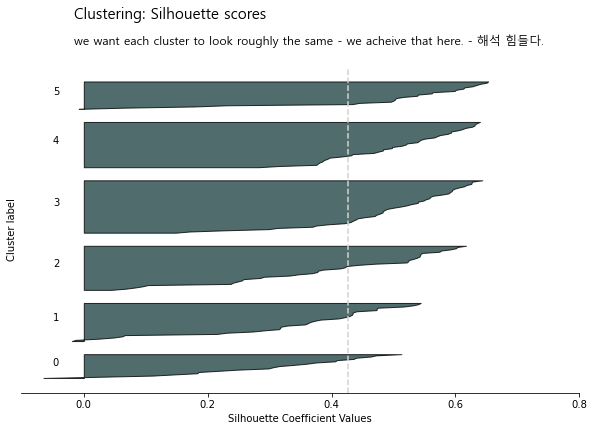

In [23]:
import matplotlib.cm as cm

clusterer = KMeans(n_clusters=6, random_state=1)
cluster_labels = clusterer.fit_predict(cluster_scaled)
silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(cluster_scaled, cluster_labels)

fig, ax1 = plt.subplots(figsize=(10,6))

y_lower = 10
for i in range(6):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 6)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor='#244747', edgecolor="black",linewidth=1, alpha=0.8)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
    
fig.text(0.198, .99, 'Clustering: Silhouette scores', fontsize=15, fontweight='bold', fontproperties=fontprop)
fig.text(0.198,.93, 'we want each cluster to look roughly the same - we acheive that here. - 해석 힘들다.', fontsize=12, fontweight='light', fontproperties=fontprop)
    

ax1.get_yaxis().set_ticks([])
#ax1.set_title("Silhouette plot for various clusters",loc='left')
ax1.set_xlabel("Silhouette Coefficient Values")
ax1.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="lightgray", linestyle="--")
ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)

plt.show()

# Silhouette score 개념:

* 데이터에 대해서 cluster에 잘 모여있고 다른 cluster와 잘 분리되어 있는지 측정한다. 
* Silhouette score는 샘플과 동일한 클러스터 내의 다른 데이터 포인트 사이의 클러스터 내 거리 (a)와 샘플과 다음으로 가장 가까운 클러스터 사이의 클러스터 간 거리 (b)를 고려한다.
* The silhouette score는 범위는 [-1,1]에 속한다. 
* 1에 가까울수록 잘 분리됐고, 잘 모여있다는 뜻이고, 0이나 -1에 가까울 수록 겹치고, 흩어져있다는 뜻이다.
* silhouette plots은 k-means clustering에서 최적의 cluster 개수를 선택하는데 사용이 된다.
* silhouette plots에서 주의해야 할 측면은 평균 silhouette score보다 낮은 cluster 점수, cluster 크기의 광범위한 변동 및 silhouette 플롯의 두께입니다.

In [24]:
clustered_data

,Spending Score (1-100),Annual Income (k$),Age,Cluster
0,39,15,19,5
1,81,15,21,5
2,6,16,20,0
3,77,16,23,5
4,40,17,31,0
...,...,...,...,...
195,79,120,35,4
196,28,126,45,1
197,74,126,32,4
198,18,137,32,1


In [25]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km2 = clustered_data.groupby(['Cluster']).mean().round(1).reset_index()
grouped_km2['Cluster'] = grouped_km2['Cluster'].map(str)
grouped_km2

,Cluster,Spending Score (1-100),Annual Income (k$),Age
0,0,19.4,26.3,45.5
1,1,17.0,88.9,41.9
2,2,47.8,57.6,26.7
3,3,49.1,54.3,56.3
4,4,82.1,86.5,32.7
5,5,76.9,25.8,25.2


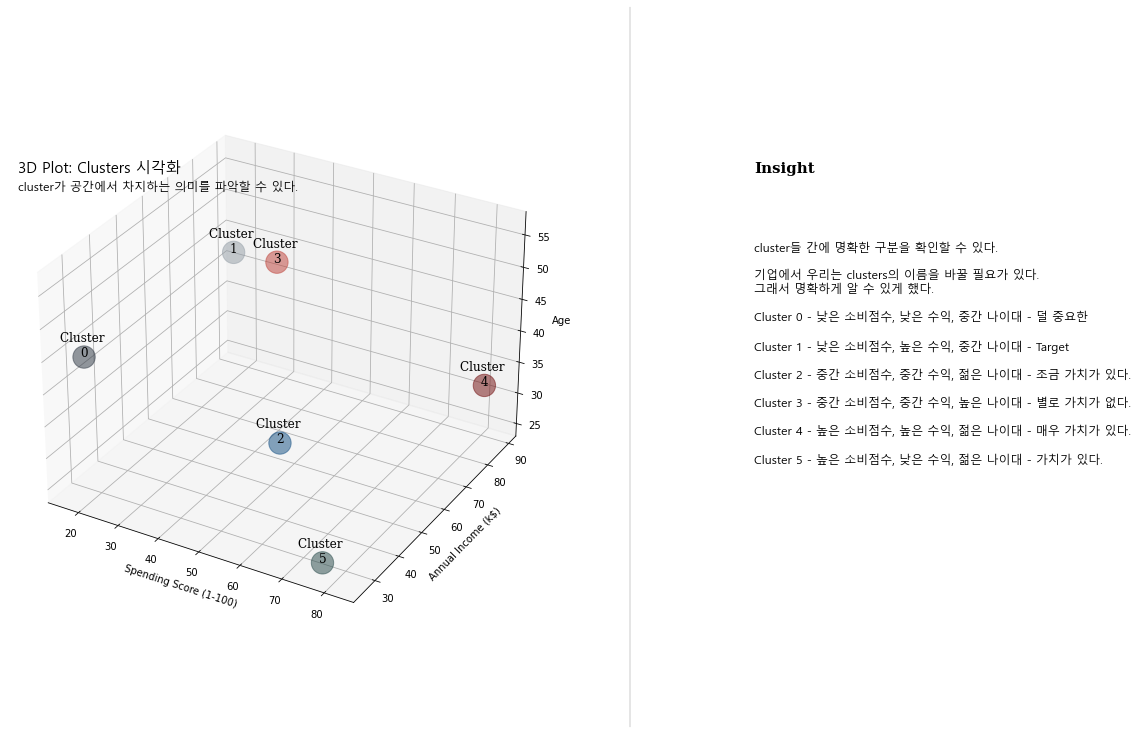

In [26]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grouped_km2["Spending Score (1-100)"], grouped_km2["Annual Income (k$)"], grouped_km2["Age"],color=['#2a333f','#939da6','#0f4c81','#be3e35','#70090a','#244747'],alpha=0.5,s=500)

# add annotations one by one with a loop
for line in range(0,grouped_km.shape[0]):
     ax.text(grouped_km2['Spending Score (1-100)'][line], grouped_km2['Annual Income (k$)'][line],grouped_km2['Age'][line], s=('Cluster \n'+grouped_km2['Cluster'][line]), horizontalalignment='center', fontsize=12, fontweight='light', fontfamily='serif')
        
ax.set_xlabel("Spending Score (1-100)")
ax.set_ylabel("Annual Income (k$)")
ax.set_zlabel("Age")

fig.text(0.15, .77, '3D Plot: Clusters 시각화', fontsize=15, fontweight='bold', fontproperties=fontprop)
fig.text(0.15, .745, 'cluster가 공간에서 차지하는 의미를 파악할 수 있다.', fontsize=12, fontweight='light', fontproperties=fontprop)

fig.text(1.172, 0.77, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(1.172, 0.347, '''
cluster들 간에 명확한 구분을 확인할 수 있다.

기업에서 우리는 clusters의 이름을 바꿀 필요가 있다. 
그래서 명확하게 알 수 있게 했다. 

Cluster 0 - 낮은 소비점수, 낮은 수익, 중간 나이대 - 덜 중요한 

Cluster 1 - 낮은 소비점수, 높은 수익, 중간 나이대 - Target

Cluster 2 - 중간 소비점수, 중간 수익, 젊은 나이대 - 조금 가치가 있다.

Cluster 3 - 중간 소비점수, 중간 수익, 높은 나이대 - 별로 가치가 없다.

Cluster 4 - 높은 소비점수, 높은 수익, 젊은 나이대 - 매우 가치가 있다.

Cluster 5 - 높은 소비점수, 낮은 수익, 젊은 나이대 - 가치가 있다.
'''
         , fontsize=12, fontweight='light', fontproperties=fontprop)

import matplotlib.lines as lines
l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])


# 평균 고객이 각 고객마다 어떻게 다른지 살펴볼 수 있다.

In [27]:
cluster_only = clustered_data[['Cluster']]

In [28]:
merge = pd.merge(df, cluster_only, left_index=True, right_index=True)
merge

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Age Range,age_band,Gender 1/0,Cluster
0,1,Male,19,15,39,Young,10 ~ 20,1,5
1,2,Male,21,15,81,Young,20 ~ 30,1,5
2,3,Female,20,16,6,Young,20 ~ 30,0,0
3,4,Female,23,16,77,Adult,20 ~ 30,0,5
4,5,Female,31,17,40,Adult,30 ~ 40,0,0
...,...,...,...,...,...,...,...,...,...
195,196,Female,35,120,79,Adult,30 ~ 40,0,4
196,197,Female,45,126,28,Adult,40 ~ 50,0,1
197,198,Male,32,126,74,Adult,30 ~ 40,1,4
198,199,Male,32,137,18,Adult,30 ~ 40,1,1


비즈니스 리더들이 중요성을 이해할 수 있게 cluster에 의미있는 이름을 붙였다. 

많은 영향을 끼치는 요소는 cluster X에 대해서 광고를 해야한다.와 높은 가치를 가진 cluster에 광고해야한다는 것이다. 

이것이 cluster를 이용하는 방법이다.


In [29]:
# Giving our clusters meaningful names

merge['Cluster_Label'] = merge['Cluster'].apply(lambda x: 'Least Valuable' if x == 0 else 
                                               'Targets' if x == 1 else
                                               'Valuable' if x == 2 else
                                               'Less Valuable' if x == 3 else
                                               'Most Valuable' if x == 4 else 'Very Valuable')




# New column for radar plots a bit later on 

merge['Sex (100=Male)'] = merge['Gender'].apply(lambda x: 100 if x == 'Male' else 0)


In [30]:
merge['Cluster'] = merge['Cluster'].map(str)
# Order for plotting categorical vars
Cluster_ord = ['0','1','2','3','4','5']
clus_label_order = ['Targets','Most Valuable','Very Valuable','Valuable','Less Valuable','Least Valuable']

In [31]:
q3_order = merge['Cluster_Label'].value_counts().index

clu_data = merge['Cluster_Label'].value_counts()[clus_label_order]
##

data_cg = merge.groupby('Cluster_Label')['Gender'].value_counts().unstack().loc[clus_label_order]
data_cg['sum'] = data_cg.sum(axis=1)

##
data_cg_ratio = (data_cg.T / data_cg['sum']).T[['Male', 'Female']][::-1]


# clusters

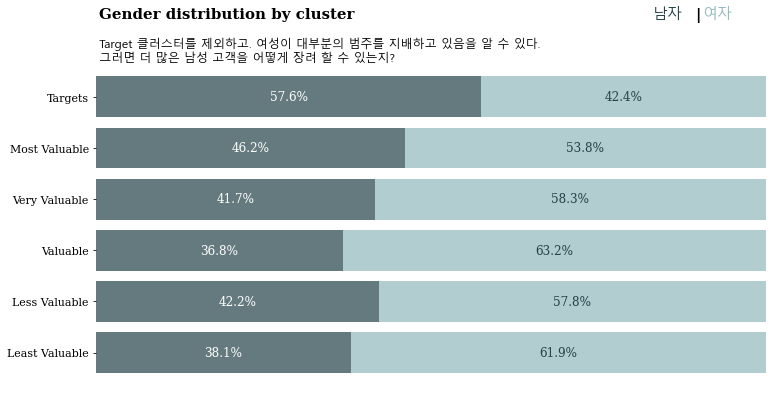

In [32]:
fig, ax = plt.subplots(1,1,figsize=(12, 6),)

ax.barh(data_cg_ratio.index, data_cg_ratio['Male'], 
        color='#244247', alpha=0.7, label='Male')
ax.barh(data_cg_ratio.index, data_cg_ratio['Female'], left=data_cg_ratio['Male'], 
        color='#91b8bd', alpha=0.7, label='Female')


ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels((data_cg_ratio.index), fontfamily='serif', fontsize=11)


# male percentage
for i in data_cg_ratio.index:
    ax.annotate(f"{data_cg_ratio['Male'][i]*100:.3}%", 
                   xy=(data_cg_ratio['Male'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')

for i in data_cg_ratio.index:
    ax.annotate(f"{data_cg_ratio['Female'][i]*100:.3}%", 
                   xy=(data_cg_ratio['Male'][i]+data_cg_ratio['Female'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='#244247')
    

fig.text(0.129, 0.98, 'Gender distribution by cluster', fontsize=15, fontweight='bold', fontfamily='serif')   
fig.text(0.085, 0.85, 
         '''
         Target 클러스터를 제외하고. 여성이 대부분의 범주를 지배하고 있음을 알 수 있다.
         그러면 더 많은 남성 고객을 어떻게 장려 할 수 있는지?
         ''' ,
         fontsize=12,fontproperties=fontprop)   

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
ax.legend().set_visible(False)

fig.text(0.77,0.98,"남자", fontweight="bold", fontproperties=fontprop, fontsize=15, color='#244247')
fig.text(0.819,0.98,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.827,0.98,"여자", fontweight="bold", fontproperties=fontprop, fontsize=15, color='#91b8bd')
plt.show()

# Insight

중요한 부분은 높은 소득이 있지만, 소비점수가 낮은 target 고객들이다. 

그리고 그들 중 대부분이 남자다. 이것을 어떻게 이용할 수 있을까?


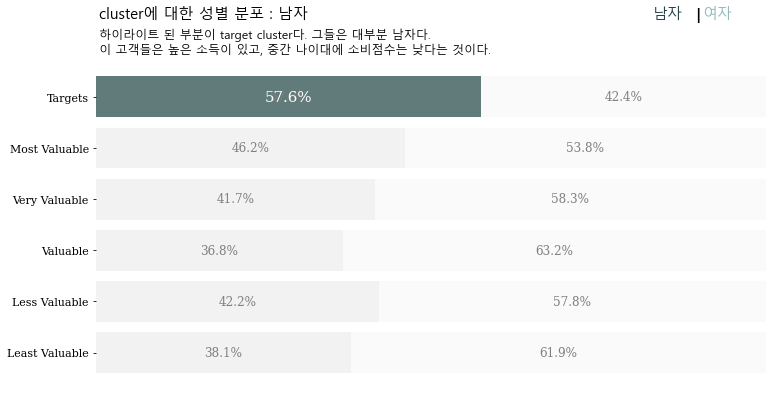

In [33]:
fig, ax = plt.subplots(1,1,figsize=(12, 6),)

ax.barh(data_cg_ratio.index, data_cg_ratio['Male'], 
        color='gray', alpha=0.1, label='Male')
ax.barh(data_cg_ratio.index, data_cg_ratio['Female'], left=data_cg_ratio['Male'], 
        color='lightgray', alpha=0.1, label='Female')

ax.barh(5, data_cg_ratio['Male']['Targets'], 
        color='#244747', alpha=0.7, label='Male')


ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels((data_cg_ratio.index), fontfamily='serif', fontsize=11)


# male percentage
for i in data_cg_ratio.index:
    ax.annotate(f"{data_cg_ratio['Male'][i]*100:.3}%", 
                   xy=(data_cg_ratio['Male'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='gray')
    
ax.annotate(f"{data_cg_ratio['Male']['Targets']*100:.3}%", 
                   xy=(data_cg_ratio['Male']['Targets']/2, 'Targets'),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')  


for i in data_cg_ratio.index:
    ax.annotate(f"{data_cg_ratio['Female'][i]*100:.3}%", 
                   xy=(data_cg_ratio['Male'][i]+data_cg_ratio['Female'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='gray')
    

fig.text(0.129, 0.98, 'cluster에 대한 성별 분포 : 남자', fontsize=15, fontweight='bold', fontproperties=fontprop)   
fig.text(0.085, 0.9, 
         '''
         하이라이트 된 부분이 target cluster다. 그들은 대부분 남자다.
         이 고객들은 높은 소득이 있고, 중간 나이대에 소비점수는 낮다는 것이다. ''' , fontsize=12,fontproperties=fontprop)   

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
ax.legend().set_visible(False)

fig.text(0.77,0.98,"남자", fontweight="bold", fontproperties=fontprop, fontsize=15, color='#244247')
fig.text(0.819,0.98,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.827,0.98,"여자", fontweight="bold", fontproperties=fontprop, fontsize=15, color='#91b8bd')
plt.show()

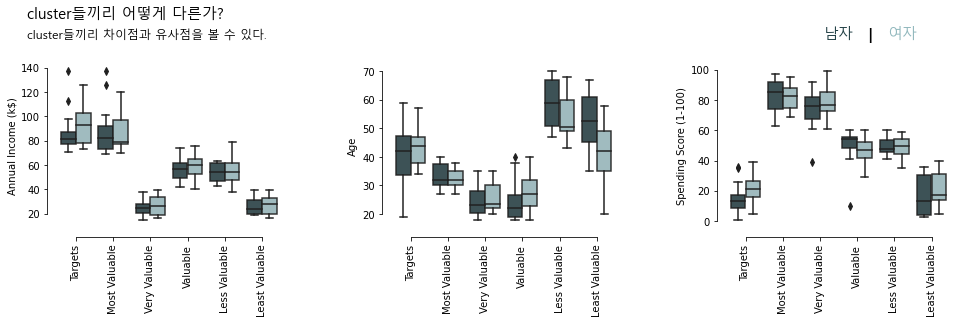

In [34]:
import matplotlib.gridspec as gridspec

# Create 2x2 sub plots
gs = gridspec.GridSpec(1, 3)

fig = plt.figure(figsize=(16, 3))

# Title and sub-title

fig.text(0.099, 1.09, 'cluster들끼리 어떻게 다른가?', fontsize=15, fontweight='bold', fontproperties=fontprop)
fig.text(0.099, 1, 'cluster들끼리 차이점과 유사점을 볼 수 있다.', fontsize=12, fontweight='light', fontproperties=fontprop)

# Grid spec layout

ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
ax1 = sns.boxplot(x='Cluster_Label',y='Annual Income (k$)',hue='Gender',data=merge,order=['Targets','Most Valuable','Very Valuable','Valuable','Less Valuable','Least Valuable'],palette=['#244247','#91b8bd'],boxprops=dict(alpha=.9))
ax1.legend_.remove() 
ax1.set_xlabel('')

ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 1
ax2 = sns.boxplot(x='Cluster_Label',y='Age',hue='Gender',data=merge,order=['Targets','Most Valuable','Very Valuable','Valuable','Less Valuable','Least Valuable'],palette=['#244247','#91b8bd'],boxprops=dict(alpha=.9))
ax2.legend_.remove() 
ax2.set_xlabel('')

ax3 = fig.add_subplot(gs[0, 2]) # row 1, span all columns
ax3 = sns.boxplot(x='Cluster_Label',y='Spending Score (1-100)',hue='Gender',data=merge,order=['Targets','Most Valuable','Very Valuable','Valuable','Less Valuable','Least Valuable'],palette=['#244247','#91b8bd'],boxprops=dict(alpha=.9))
ax3.legend_.remove() 
ax3.set_xlabel('')

sns.despine(right=True)
sns.despine(offset=10, trim=True)

ax.legend().set_visible(False)
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
for tick in ax3.get_xticklabels():
    tick.set_rotation(90)



fig.text(0.79,1,"남자", fontweight="bold", fontproperties=fontprop, fontsize=15, color='#244247')
fig.text(0.828,1,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.845,1,"여자", fontweight="bold", fontproperties=fontprop, fontsize=15, color='#91b8bd')


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None) # useful for adjusting space between subplots

# 차이점을 시각화할 방법들

cluster 2와 3은 비슷해 보인다.

In [35]:
# Radar Plots
clustered_data = merge
clustered_data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Age Range,age_band,Gender 1/0,Cluster,Cluster_Label,Sex (100=Male)
0,1,Male,19,15,39,Young,10 ~ 20,1,5,Very Valuable,100
1,2,Male,21,15,81,Young,20 ~ 30,1,5,Very Valuable,100
2,3,Female,20,16,6,Young,20 ~ 30,0,0,Least Valuable,0
3,4,Female,23,16,77,Adult,20 ~ 30,0,5,Very Valuable,0
4,5,Female,31,17,40,Adult,30 ~ 40,0,0,Least Valuable,0
...,...,...,...,...,...,...,...,...,...,...,...
195,196,Female,35,120,79,Adult,30 ~ 40,0,4,Most Valuable,0
196,197,Female,45,126,28,Adult,40 ~ 50,0,1,Targets,0
197,198,Male,32,126,74,Adult,30 ~ 40,1,4,Most Valuable,100
198,199,Male,32,137,18,Adult,30 ~ 40,1,1,Targets,100


In [36]:


clus0 = clustered_data[clustered_data['Cluster_Label'] == 'Least Valuable']
clus1 = clustered_data[clustered_data['Cluster_Label'] == 'Targets']
clus2 = clustered_data[clustered_data['Cluster_Label'] == 'Valuable']
clus3 = clustered_data[clustered_data['Cluster_Label'] == 'Less Valuable']
clus4 = clustered_data[clustered_data['Cluster_Label'] == 'Most Valuable']
clus5 = clustered_data[clustered_data['Cluster_Label'] == 'Very Valuable']

labels=np.array(['Age', 'Annual Income (k$)', 'Spending Score (1-100)','Sex (100=Male)'])
stats0=clus0.loc[:,labels].mean()
stats1=clus1.loc[:,labels].mean()
stats2=clus2.loc[:,labels].mean()
stats3=clus3.loc[:,labels].mean()
stats4=clus4.loc[:,labels].mean()
stats5=clus5.loc[:,labels].mean()


angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)

# close the plot
stats0=np.concatenate((stats0,[stats0[0]]))
stats1=np.concatenate((stats1,[stats1[0]]))
stats2=np.concatenate((stats2,[stats2[0]]))
stats3=np.concatenate((stats3,[stats3[0]]))
stats4=np.concatenate((stats4,[stats4[0]]))
stats5=np.concatenate((stats5,[stats5[0]]))



angles=np.concatenate((angles,[angles[0]]))

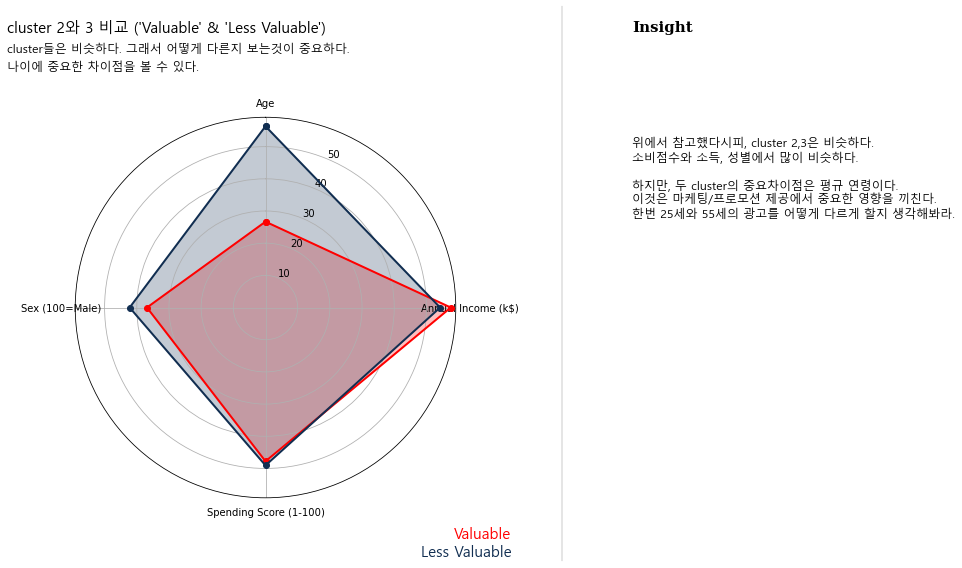

In [37]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
fig, ax = plt.subplots(1, 1, figsize=(7,7))

ax = plt.subplot(111, polar=True)

ax.plot(angles, stats2, 'o-', linewidth=2, color='#ff0000', label="Cluster 2: Valuable")
ax.fill(angles, stats2, color='#ff0000',alpha=0.25)

ax.plot(angles, stats3, 'o-', linewidth=2,color='#112e51',label="Cluster 3: Less Valuable")
ax.fill(angles, stats3, color='#112e51',alpha=0.25)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

ax.set_thetagrids((angles * 180/np.pi)[0:4],labels) # Chnage this to match label count


fig.text(0, 1.05, "cluster 2와 3 비교 ('Valuable' & 'Less Valuable')", fontsize=15, fontweight='bold', fontproperties=fontprop)
fig.text(0,1.01, 'cluster들은 비슷하다. 그래서 어떻게 다른지 보는것이 중요하다.', fontsize=12, fontweight='light', fontproperties=fontprop)
fig.text(0,0.975, '나이에 중요한 차이점을 볼 수 있다.', fontsize=12, fontweight='light', fontproperties=fontprop)

fig.text(1.24, 1.05, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(1.24, 0.655, '''
위에서 참고했다시피, cluster 2,3은 비슷하다. 
소비점수와 소득, 성별에서 많이 비슷하다.

하지만, 두 cluster의 중요차이점은 평규 연령이다.
이것은 마케팅/프로모션 제공에서 중요한 영향을 끼친다.
한번 25세와 55세의 광고를 어떻게 다르게 할지 생각해봐라.
'''
         , fontsize=12, fontweight='light', fontproperties=fontprop)

import matplotlib.lines as lines
l1 = lines.Line2D([1.1, 1.1], [0, 1.1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])

fig.text(1,0.045,"Valuable", fontweight="bold",fontproperties=fontprop, ha='right',fontsize=15, color='#ff0000')
fig.text(1,0.01,"Less Valuable", fontweight="bold",fontproperties=fontprop,ha='right', fontsize=15, color='#112e51')

ax.grid(True)

In [38]:
df = clustered_data[['Cluster_Label','Age','Annual Income (k$)','Spending Score (1-100)','Sex (100=Male)']]

df = df.groupby('Cluster_Label')['Cluster_Label','Age','Annual Income (k$)','Spending Score (1-100)','Sex (100=Male)'].mean().reset_index()


In [39]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Par1 : cluster에 맞는 spider plot을 위한 함수를 작성한다. 

def make_spider( row, title, color):
 
    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3,3,row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black',fontfamily='serif',fontweight='light', size=8)
    #ax.set_xticks([]) # turn labels off if you want - can look quite nice

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30,40,50,75,100], ["10","20","30","40","50","75","100"], color="grey", size=4)
    plt.ylim(0,100)

    # Ind1
    values=df.loc[row].drop('Cluster_Label').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=10, fontfamily='serif',fontweight='bold', y=1.2)
    plt.tight_layout()


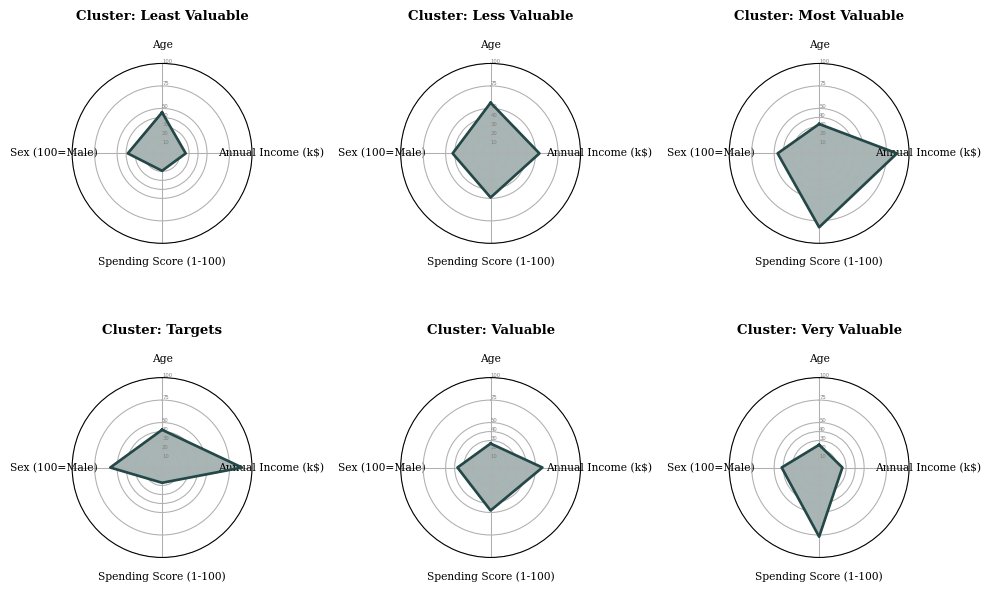

In [40]:
# Part 2 : 각각에 적용한다. 
my_dpi=96

plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("crest", len(df.index))
 
# Loop to plot
for row in range(0, len(df.index)):
    make_spider( row=row, title='Cluster: '+df['Cluster_Label'][row], color='#244747') #change this to my_palette if you want colour to vary by cluster
    

# most valuable cluster와 least valuable cluster를 비교한다. 

무엇을 볼 수 있나?

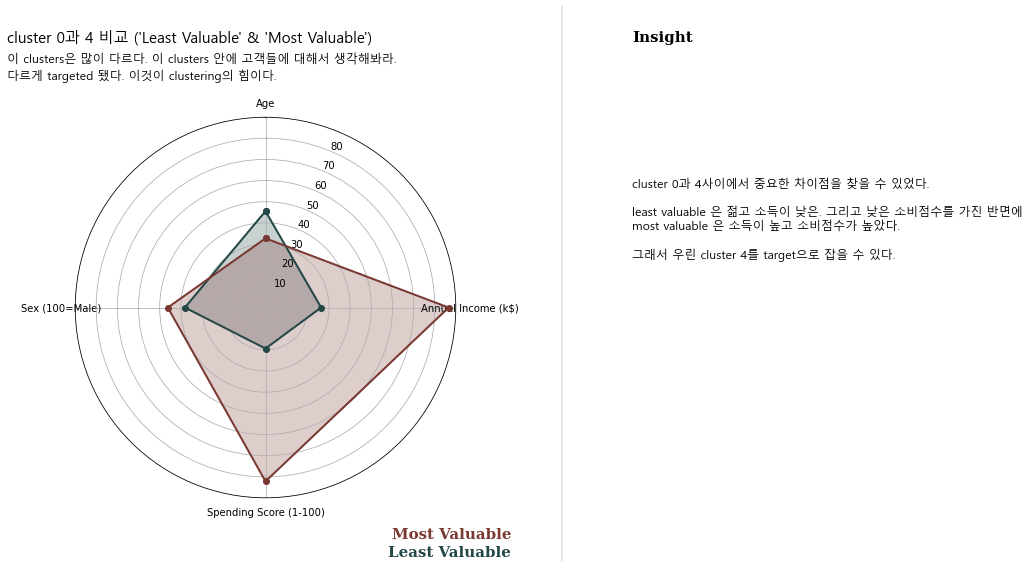

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))

ax = plt.subplot(111, polar=True)



ax.plot(angles, stats0, 'o-', linewidth=2, color='#244747', label="Cluster 0")
ax.fill(angles, stats0, color='#244747',alpha=0.25)

ax.plot(angles, stats4, 'o-', linewidth=2,color='#7A3832',label="Cluster 4")
ax.fill(angles, stats4, color='#7A3832',alpha=0.25)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

ax.set_thetagrids((angles * 180/np.pi)[0:4],labels)


fig.text(0, 1.03, "cluster 0과 4 비교 ('Least Valuable' & 'Most Valuable')", fontsize=15, fontweight='bold', fontproperties=fontprop)
fig.text(0,0.99, '이 clusters은 많이 다르다. 이 clusters 안에 고객들에 대해서 생각해봐라.', fontsize=12, fontweight='light',  fontproperties=fontprop)
fig.text(0,0.955, '다르게 targeted 됐다. 이것이 clustering의 힘이다.', fontsize=12, fontweight='light',  fontproperties=fontprop)


fig.text(1.24, 1.03, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(1.24, 0.574, '''
cluster 0과 4사이에서 중요한 차이점을 찾을 수 있었다.

least valuable 은 젊고 소득이 낮은. 그리고 낮은 소비점수를 가진 반면에
most valuable 은 소득이 높고 소비점수가 높았다. 

그래서 우린 cluster 4를 target으로 잡을 수 있다.
'''
         , fontsize=12, fontweight='light', fontproperties=fontprop)

import matplotlib.lines as lines
l1 = lines.Line2D([1.1, 1.1], [0, 1.1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])


fig.text(1,0.045,"Most Valuable", fontweight="bold", fontfamily='serif', ha='right',fontsize=15, color='#7A3832')
fig.text(1,0.01,"Least Valuable", fontweight="bold", fontfamily='serif',ha='right', fontsize=15, color='#244747')


ax.grid(True)

In [42]:
df_hm = df.set_index('Cluster_Label')
df_hm = df_hm.reindex(['Targets',
 'Most Valuable',
 'Very Valuable',
 'Valuable',
 'Less Valuable',
 'Least Valuable'])


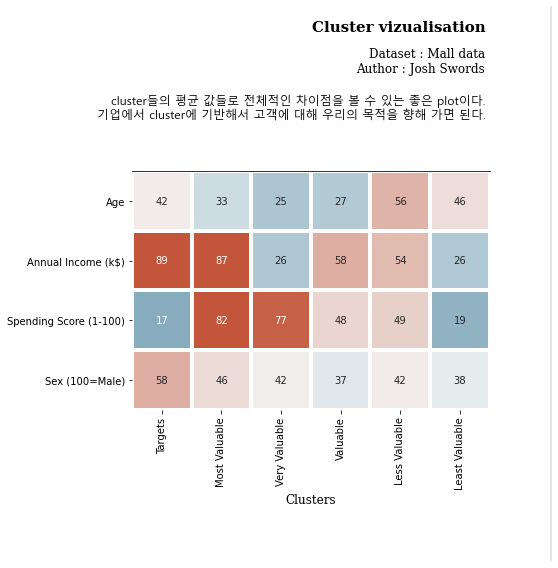

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))


cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_hm.T, 
            square=True,
            linewidth=3, 
            vmax=80, vmin=1, 
            cmap=cmap, 
            cbar=False, 
            ax=ax,annot=True)

ax.spines['top'].set_visible(True)

fig.text(0.97, 1.05, 'Cluster vizualisation', fontweight='bold', fontfamily='serif', fontsize=15, ha='right')    
fig.text(0.97, 0.97, 'Dataset : Mall data\nAuthor : Josh Swords', fontweight='light', fontfamily='serif', fontsize=12, ha='right')    

fig.text(0.97, 0.955, '''
cluster들의 평균 값들로 전체적인 차이점을 볼 수 있는 좋은 plot이다.
기업에서 cluster에 기반해서 고객에 대해 우리의 목적을 향해 가면 된다.
''', 
         fontweight='light', fontproperties=fontprop, fontsize=12, va='top', ha='right') 

import matplotlib.lines as lines
l1 = lines.Line2D([1.1, 1.1], [0, 1.1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])

plt.xlabel("Clusters", fontsize=12, fontweight='light', fontfamily='serif')



plt.tight_layout()
plt.show()

# cluster를 볼 수 있는 다른 방법들

In [44]:
data = merge[['Gender','age_band','Cluster_Label']]


# Adding a single female to the age range 70-80 for the purposes of this visualization, not reccomended in the real world!

data.loc[-1] = ['Female', '70 ~ 80', 'Less Valuable']  # adding a row
data.index = data.index + 1  # shifting index
data = data.sort_index()  # sorting by index
data['count']=1

In [45]:
age_range_order = ['10 ~ 20', '20 ~ 30', '30 ~ 40','40 ~ 50','50 ~ 60','60 ~ 70','70 ~ 80'] #q15

  
clus_label_order = ['Targets',
 'Most Valuable',
 'Very Valuable',
 'Valuable',
 'Less Valuable',
 'Least Valuable'] 
 
data['count'] = 1


data_ca = pd.pivot_table(data, values='count', index=['Cluster_Label'], columns=['age_band'], aggfunc=np.sum).fillna(0).astype(int).loc[clus_label_order, age_range_order].stack()
data_ca_man = pd.pivot_table(data[data['Gender']=='Male'], values='count', index=['Cluster_Label'], columns=['age_band'], aggfunc=np.sum).fillna(0).astype(int).loc[clus_label_order, age_range_order].stack()
data_ca_woman = pd.pivot_table(data[data['Gender']=='Female'], values='count', index=['Cluster_Label'], columns=['age_band'], aggfunc=np.sum).fillna(0).astype(int).loc[clus_label_order, age_range_order].stack()


In [46]:
# https://stackoverflow.com/questions/56337732/how-to-plot-scatter-pie-chart-using-matplotlib
def drawPieMarker(xs, ys, ratios, sizes, colors, ax):
    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 30)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 30)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color})

    # scatter each of the pie pieces to create pies
    for marker in markers:
        ax.scatter(xs, ys, **marker, alpha=0.9)


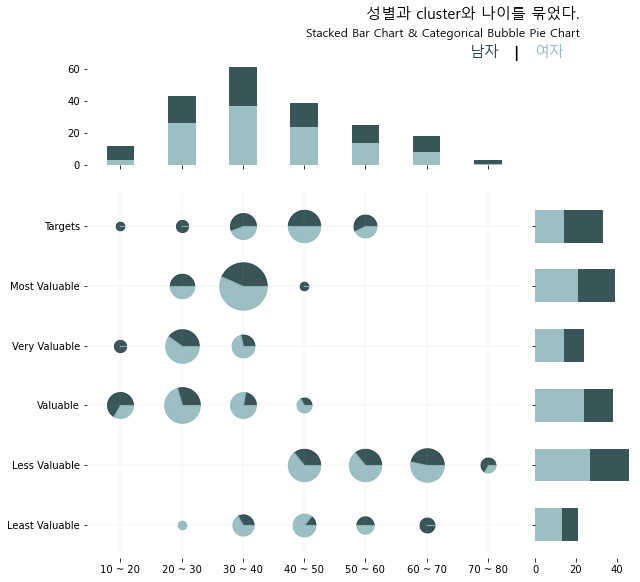

In [54]:
fig = plt.figure(figsize=(9, 9))

gs = fig.add_gridspec(5, 5)

# Pie charts

ax_plot = fig.add_subplot(gs[1:4, 0:4]) 
for cl_idx in clus_label_order[::-1]:
    for age_idx in age_range_order:
        man = data_ca_man[cl_idx][age_idx]
        woman = data_ca_woman[cl_idx][age_idx]
        tot = data_ca[cl_idx][age_idx]
        drawPieMarker([age_idx],[cl_idx], [man/(man+woman), woman/(man+woman)] ,[tot*75], ['#244247', '#91b8bd'], ax=ax_plot)

ax_plot.grid(linewidth=0.1)        



 # Top
ax_pos = fig.add_subplot(gs[0, :4], sharex=ax_plot) 
data_age_woman = data[data['Gender']=='Female']['age_band'].value_counts()[age_range_order]
ax_pos.bar(data_age_woman.index, data_age_woman, width=0.45, alpha=0.9, color='#91b8bd')

data_age_man = data[data['Gender']=='Male']['age_band'].value_counts()[age_range_order]
ax_pos.bar(data_age_man.index, data_age_man, bottom=data_age_woman , width=0.45, alpha=0.9, color='#244247')

plt.setp(ax_pos.get_xticklabels(), visible=False)


# Side 
ax_exp = fig.add_subplot(gs[1:4, 4], sharey=ax_plot) 

data_cl_woman = data[data['Gender']=='Female']['Cluster_Label'].value_counts()[clus_label_order]
ax_exp.barh(data_cl_woman.index[::-1], data_cl_woman[::-1], height=0.55, alpha=0.9, color='#91b8bd')

data_cl_man = data[data['Gender']=='Male']['Cluster_Label'].value_counts()[clus_label_order]
ax_exp.barh(data_cl_man.index[::-1], data_cl_man[::-1], left= data_cl_woman[::-1],height=0.55, alpha=0.9, color='#244247')

plt.setp(ax_exp.get_yticklabels(), visible=False)


# Spines
for s in ['top', 'left', 'right', 'bottom']:
    ax_plot.spines[s].set_visible(False)
    ax_pos.spines[s].set_visible(False)
    ax_exp.spines[s].set_visible(False)
ax.set_axisbelow(True)    

fig.text(0.9, 1.05, '성별과 cluster와 나이를 묶었다.', fontweight='bold', fontproperties=fontprop, fontsize=15, ha='right') 
fig.text(0.9, 1.023, 'Stacked Bar Chart & Categorical Bubble Pie Chart', fontweight='light',  fontproperties=fontprop, fontsize=12, ha='right')

fig.text(0.73,0.992,"남자", fontweight="bold",  fontproperties=fontprop, fontsize=15, color='#244247')
fig.text(0.798,0.992,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.83,0.992,"여자", fontweight="bold",  fontproperties=fontprop, fontsize=15, color='#91b8bd')

plt.tight_layout()
plt.show()

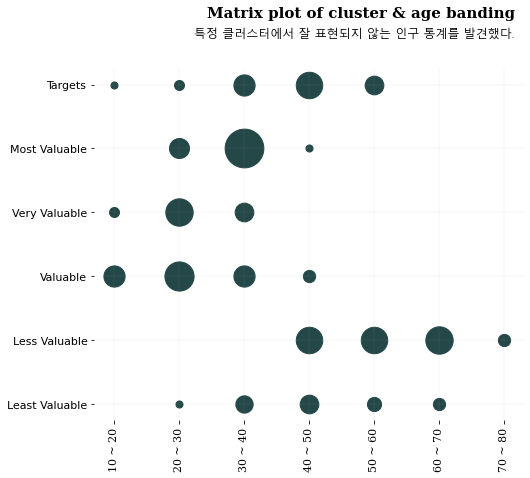

In [55]:

fig = plt.figure(figsize=(9, 9))

gs = fig.add_gridspec(5, 5)

fig.text(0.8, 0.85, 'Matrix plot of cluster & age banding', fontweight='bold', fontfamily='serif', fontsize=15, ha='right') 
fig.text(0.8, 0.82, '특정 클러스터에서 잘 표현되지 않는 인구 통계를 발견했다.', fontweight='light', fontproperties=fontprop, fontsize=12, ha='right')



# Pie charts  / Matrix plot

ax_plot = fig.add_subplot(gs[1:4, 0:4]) 
for cl_idx in clus_label_order[::-1]:
    for age_idx in age_range_order:
        
        tot = data_ca[cl_idx][age_idx]
        ax_plot.scatter(age_idx, cl_idx, s=tot*50, color='#244747')    

ax_plot.grid(linewidth=0.1)        
ax_plot.set_xticklabels(age_range_order,fontfamily='serif', fontsize=11, rotation=90)
plt.yticks(fontsize=11)


# Spines
for s in ['top', 'left', 'right', 'bottom']:
    ax_plot.spines[s].set_visible(False)
    ax_pos.spines[s].set_visible(False)
    ax_exp.spines[s].set_visible(False)
    
#sns.despine(offset=20, trim=True)
ax.set_axisbelow(True)   

plt.tight_layout()